# PHASE 2.5: Advanced ML & BERT Fine-tuning
## Advanced Machine Learning Techniques

This notebook covers advanced AI components:
- Fine-tuning BERT on COVID-19 tweets
- Cross-validation & hyperparameter tuning
- ROC-AUC curves and advanced metrics
- Ensemble methods (Voting, Stacking, XGBoost)
- Model interpretability (SHAP values)
- Learning curves and model comparison

In [4]:
!pip install transformers[torch] accelerate -U

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# PyTorch and Transformers
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import learning_curve

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except:
    print("XGBoost not available. Install with: pip install xgboost")
    XGBOOST_AVAILABLE = False

# SHAP for interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except:
    print("SHAP not available. Install with: pip install shap")
    SHAP_AVAILABLE = False

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

Using device: cuda


## Load Data and Embeddings from Phase 2

In [4]:
# Load processed data
df = pd.read_csv('covid19_tweets_with_predictions.csv')
print(f"Dataset loaded: {len(df):,} tweets")

# Load BERT embeddings
embeddings = np.load('bert_embeddings.npy')
print(f"Embeddings loaded: {embeddings.shape}")

print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nClass balance: {df['label'].value_counts(normalize=True).round(3)}")

Dataset loaded: 10,000 tweets
Embeddings loaded: (10000, 768)

Label distribution:
label
1    7636
0    2364
Name: count, dtype: int64

Class balance: label
1    0.764
0    0.236
Name: proportion, dtype: float64


## Part 1: Cross-Validation & Hyperparameter Tuning
### Proper model evaluation and optimization

In [5]:
# Prepare data for cross-validation
X = embeddings
y = df['label'].values

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 8000 samples
Test set: 2000 samples


### Cross-Validation for Random Forest

Performing 5-fold cross-validation for Random Forest...

Cross-validation F1 scores: [0.88382353 0.88995569 0.88448845 0.89522399 0.88553552]
Mean F1: 0.8878 (+/- 0.0086)


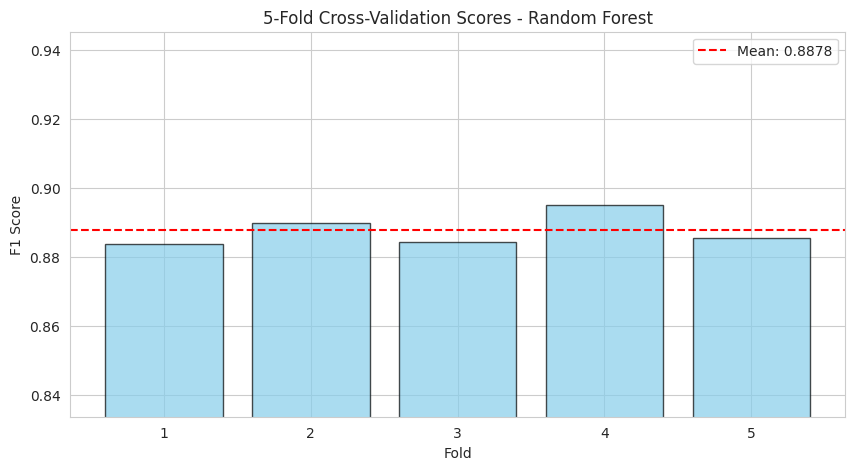

In [6]:
# Perform 5-fold cross-validation
print("Performing 5-fold cross-validation for Random Forest...")

rf_base = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

cv_scores = cross_val_score(rf_base, X_train, y_train, cv=5, scoring='f1')

print(f"\nCross-validation F1 scores: {cv_scores}")
print(f"Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualize CV scores
plt.figure(figsize=(10, 5))
plt.bar(range(1, 6), cv_scores, alpha=0.7, color='skyblue', edgecolor='black')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('5-Fold Cross-Validation Scores - Random Forest')
plt.legend()
plt.ylim([cv_scores.min() - 0.05, cv_scores.max() + 0.05])
plt.show()

### Hyperparameter Tuning with Grid Search

In [7]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print("Performing Grid Search for Random Forest...")
print(f"Testing {np.prod([len(v) for v in param_grid.values()])} combinations")
print("This may take 10-20 minutes...\n")

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print(f"\n{'='*60}")
print("Grid Search Results")
print(f"{'='*60}")
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best cross-validation F1 score: {rf_grid.best_score_:.4f}")

# Get best model
best_rf = rf_grid.best_estimator_

Performing Grid Search for Random Forest...
Testing 36 combinations
This may take 10-20 minutes...

Fitting 3 folds for each of 36 candidates, totalling 108 fits

Grid Search Results
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation F1 score: 0.8863


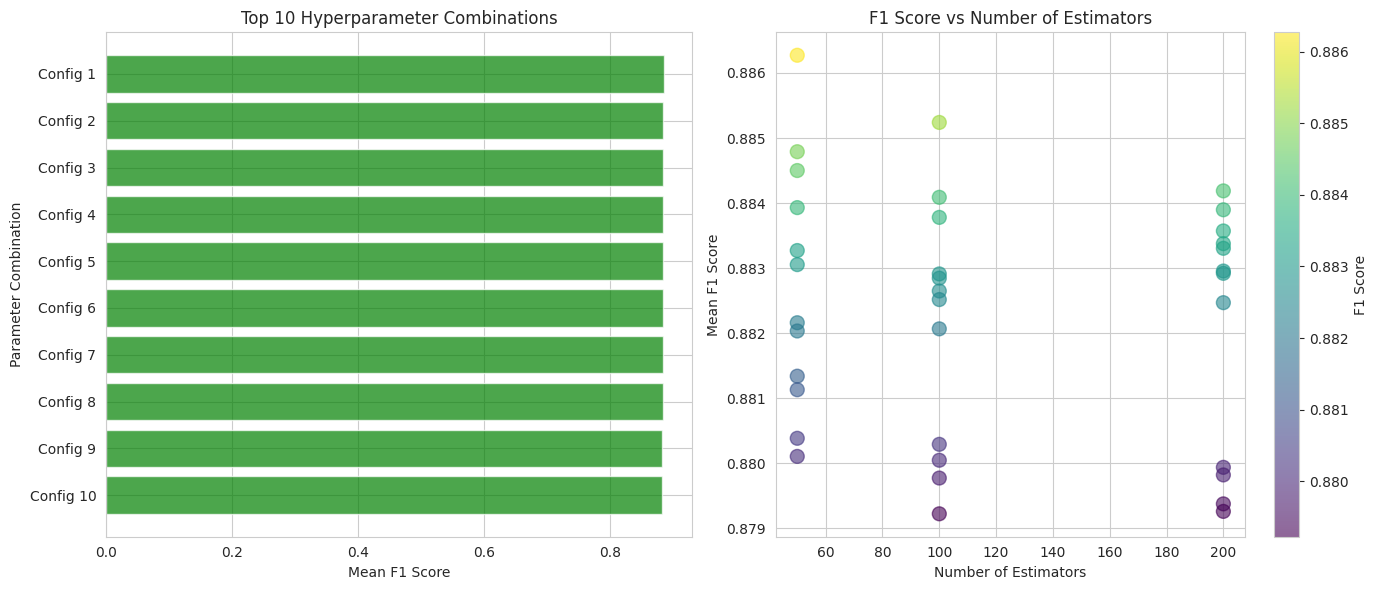

In [8]:
# Visualize grid search results
results_df = pd.DataFrame(rf_grid.cv_results_)
results_df = results_df.sort_values('rank_test_score')

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
top_10 = results_df.head(10)
plt.barh(range(len(top_10)), top_10['mean_test_score'], color='green', alpha=0.7)
plt.xlabel('Mean F1 Score')
plt.ylabel('Parameter Combination')
plt.title('Top 10 Hyperparameter Combinations')
plt.yticks(range(len(top_10)), [f"Config {i+1}" for i in range(len(top_10))])
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.scatter(results_df['param_n_estimators'], results_df['mean_test_score'],
           alpha=0.6, s=100, c=results_df['mean_test_score'], cmap='viridis')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean F1 Score')
plt.title('F1 Score vs Number of Estimators')
plt.colorbar(label='F1 Score')
plt.tight_layout()
plt.show()

### Logistic Regression with Hyperparameter Tuning

In [9]:
# Hyperparameter tuning for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

print("Performing Grid Search for Logistic Regression...")

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

lr_grid.fit(X_train, y_train)

print(f"\nBest parameters: {lr_grid.best_params_}")
print(f"Best cross-validation F1 score: {lr_grid.best_score_:.4f}")

best_lr = lr_grid.best_estimator_

Performing Grid Search for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation F1 score: 0.9189


## Part 2: XGBoost Classifier
### Advanced gradient boosting

In [10]:
if XGBOOST_AVAILABLE:
    print("Training XGBoost classifier...")

    # Calculate scale_pos_weight for imbalanced data
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    xgb_classifier = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1
    )

    xgb_classifier.fit(X_train, y_train)

    # Predictions
    y_pred_xgb = xgb_classifier.predict(X_test)
    y_pred_proba_xgb = xgb_classifier.predict_proba(X_test)[:, 1]

    print("\nXGBoost Results:")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred_xgb):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred_xgb):.4f}")
    print(f"F1-Score:  {f1_score(y_test, y_pred_xgb):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
else:
    print("XGBoost not available. Skipping...")
    xgb_classifier = None

Training XGBoost classifier...

XGBoost Results:
Accuracy:  0.8565
Precision: 0.9058
Recall:    0.9064
F1-Score:  0.9061
ROC-AUC:   0.9145


## Part 3: ROC-AUC Curves and Advanced Metrics

In [11]:
# Get predictions and probabilities from all models
y_pred_rf = best_rf.predict(X_test)
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

y_pred_lr = best_lr.predict(X_test)
y_pred_proba_lr = best_lr.predict_proba(X_test)[:, 1]

print("Predictions generated for all models.")

Predictions generated for all models.


### ROC Curves

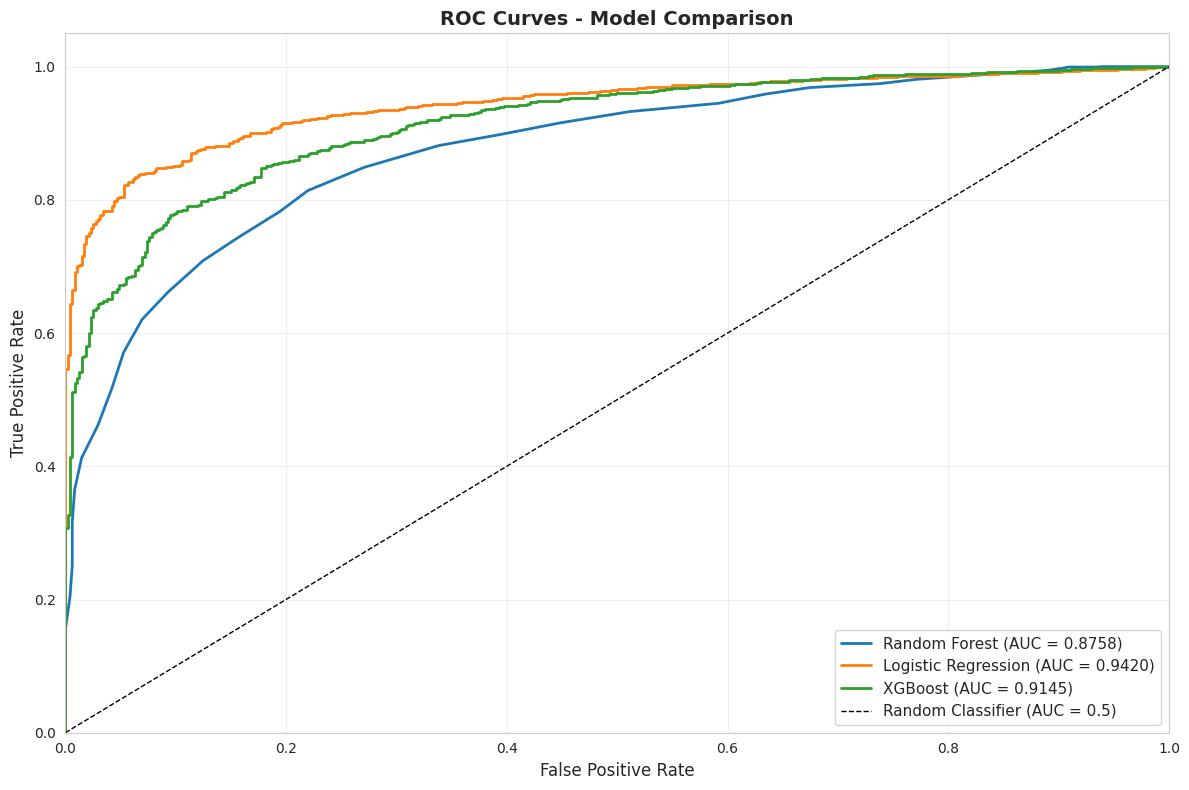


ROC-AUC Scores:
Random Forest:       0.8758
Logistic Regression: 0.9420
XGBoost:             0.9145


In [12]:
# Calculate ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

# Plot ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})', linewidth=2)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})', linewidth=2)

if XGBOOST_AVAILABLE and xgb_classifier:
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
    roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
    plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC-AUC Scores:")
print(f"Random Forest:       {roc_auc_rf:.4f}")
print(f"Logistic Regression: {roc_auc_lr:.4f}")
if XGBOOST_AVAILABLE and xgb_classifier:
    print(f"XGBoost:             {roc_auc_xgb:.4f}")

### Precision-Recall Curves

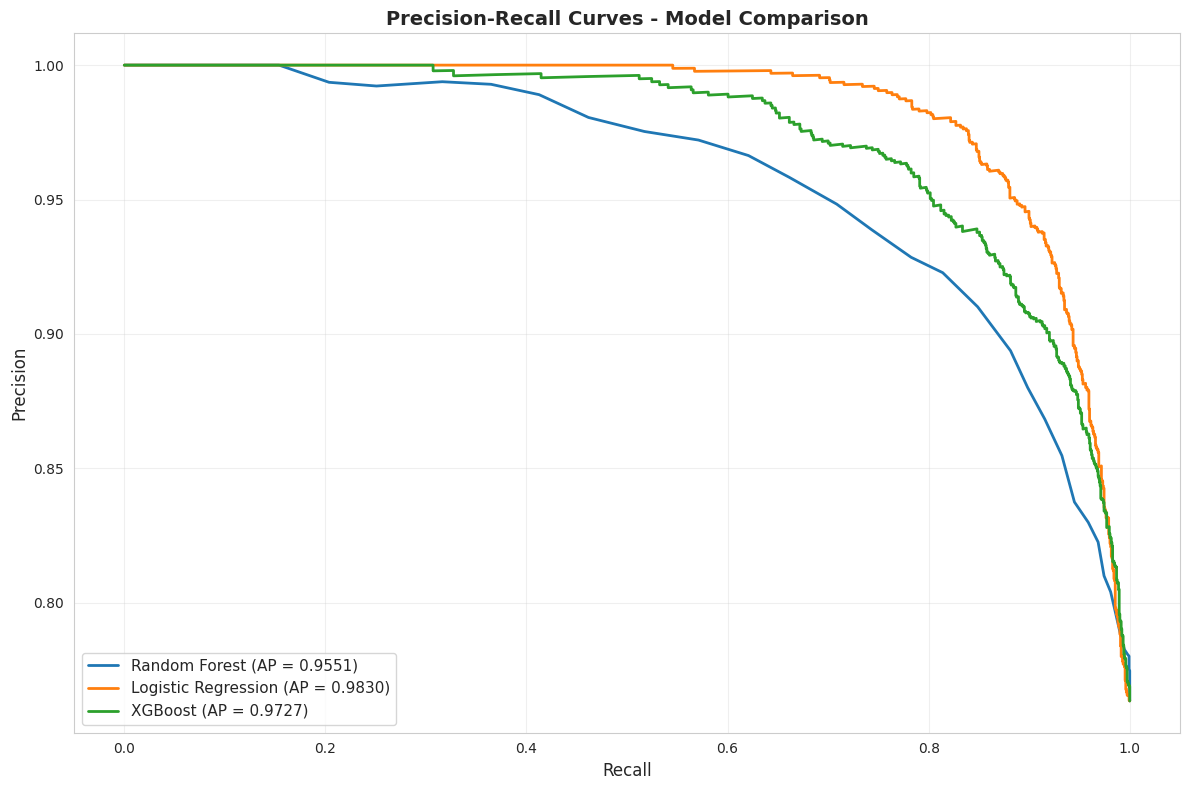

In [13]:
# Calculate Precision-Recall curves
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
ap_rf = average_precision_score(y_test, y_pred_proba_rf)

precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
ap_lr = average_precision_score(y_test, y_pred_proba_lr)

# Plot Precision-Recall curves
plt.figure(figsize=(12, 8))
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {ap_rf:.4f})', linewidth=2)
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AP = {ap_lr:.4f})', linewidth=2)

if XGBOOST_AVAILABLE and xgb_classifier:
    precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
    ap_xgb = average_precision_score(y_test, y_pred_proba_xgb)
    plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.4f})', linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Detailed Classification Reports

In [14]:
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORTS")
print("="*70)

print("\n1. RANDOM FOREST (Tuned):")
print("-" * 70)
print(classification_report(y_test, y_pred_rf, target_names=['Non-Disease', 'Disease']))

print("\n2. LOGISTIC REGRESSION (Tuned):")
print("-" * 70)
print(classification_report(y_test, y_pred_lr, target_names=['Non-Disease', 'Disease']))

if XGBOOST_AVAILABLE and xgb_classifier:
    print("\n3. XGBOOST:")
    print("-" * 70)
    print(classification_report(y_test, y_pred_xgb, target_names=['Non-Disease', 'Disease']))


DETAILED CLASSIFICATION REPORTS

1. RANDOM FOREST (Tuned):
----------------------------------------------------------------------
              precision    recall  f1-score   support

 Non-Disease       0.76      0.26      0.39       473
     Disease       0.81      0.97      0.88      1527

    accuracy                           0.81      2000
   macro avg       0.79      0.62      0.64      2000
weighted avg       0.80      0.81      0.77      2000


2. LOGISTIC REGRESSION (Tuned):
----------------------------------------------------------------------
              precision    recall  f1-score   support

 Non-Disease       0.78      0.68      0.72       473
     Disease       0.90      0.94      0.92      1527

    accuracy                           0.88      2000
   macro avg       0.84      0.81      0.82      2000
weighted avg       0.87      0.88      0.87      2000


3. XGBOOST:
----------------------------------------------------------------------
              precision    

### Confusion Matrices Comparison

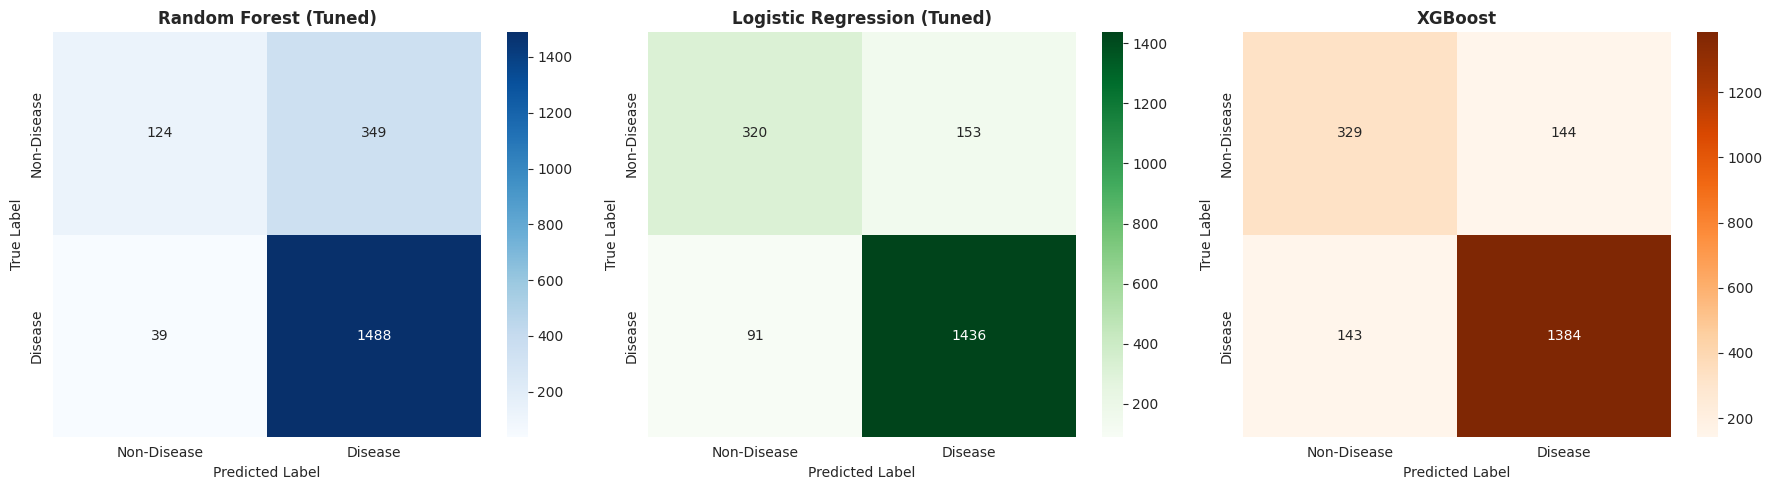

In [15]:
# Create confusion matrices
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_lr = confusion_matrix(y_test, y_pred_lr)

fig, axes = plt.subplots(1, 3 if (XGBOOST_AVAILABLE and xgb_classifier) else 2, figsize=(18, 5))

# Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-Disease', 'Disease'],
            yticklabels=['Non-Disease', 'Disease'])
axes[0].set_title('Random Forest (Tuned)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Logistic Regression
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Non-Disease', 'Disease'],
            yticklabels=['Non-Disease', 'Disease'])
axes[1].set_title('Logistic Regression (Tuned)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

# XGBoost
if XGBOOST_AVAILABLE and xgb_classifier:
    cm_xgb = confusion_matrix(y_test, y_pred_xgb)
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
                xticklabels=['Non-Disease', 'Disease'],
                yticklabels=['Non-Disease', 'Disease'])
    axes[2].set_title('XGBoost', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('True Label')
    axes[2].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## Part 4: Ensemble Methods
### Combining multiple models for better performance

### Voting Classifier

In [16]:
print("Training Voting Classifier (Soft Voting)...")

# Create ensemble of models
estimators = [
    ('rf', best_rf),
    ('lr', best_lr)
]

if XGBOOST_AVAILABLE and xgb_classifier:
    estimators.append(('xgb', xgb_classifier))

voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft',  # Use probability averaging
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)

# Predictions
y_pred_voting = voting_clf.predict(X_test)
y_pred_proba_voting = voting_clf.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("VOTING CLASSIFIER RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_voting):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_voting):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_voting):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_voting):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_voting):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_voting, target_names=['Non-Disease', 'Disease']))

Training Voting Classifier (Soft Voting)...

VOTING CLASSIFIER RESULTS
Accuracy:  0.8790
Precision: 0.8954
Recall:    0.9528
F1-Score:  0.9232
ROC-AUC:   0.9354

Classification Report:
              precision    recall  f1-score   support

 Non-Disease       0.81      0.64      0.71       473
     Disease       0.90      0.95      0.92      1527

    accuracy                           0.88      2000
   macro avg       0.85      0.80      0.82      2000
weighted avg       0.87      0.88      0.87      2000



### Stacking Classifier

In [17]:
print("Training Stacking Classifier...")

# Base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
]

# Meta-learner
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)

# Predictions
y_pred_stacking = stacking_clf.predict(X_test)
y_pred_proba_stacking = stacking_clf.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("STACKING CLASSIFIER RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_stacking):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_stacking):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_stacking):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_stacking):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_stacking):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_stacking, target_names=['Non-Disease', 'Disease']))

Training Stacking Classifier...

STACKING CLASSIFIER RESULTS
Accuracy:  0.8810
Precision: 0.9036
Recall:    0.9450
F1-Score:  0.9238
ROC-AUC:   0.9408

Classification Report:
              precision    recall  f1-score   support

 Non-Disease       0.79      0.67      0.73       473
     Disease       0.90      0.94      0.92      1527

    accuracy                           0.88      2000
   macro avg       0.85      0.81      0.83      2000
weighted avg       0.88      0.88      0.88      2000



## Part 5: Learning Curves
### Analyze model performance vs training size

Generating learning curves... This may take a few minutes.

1. Random Forest Learning Curve


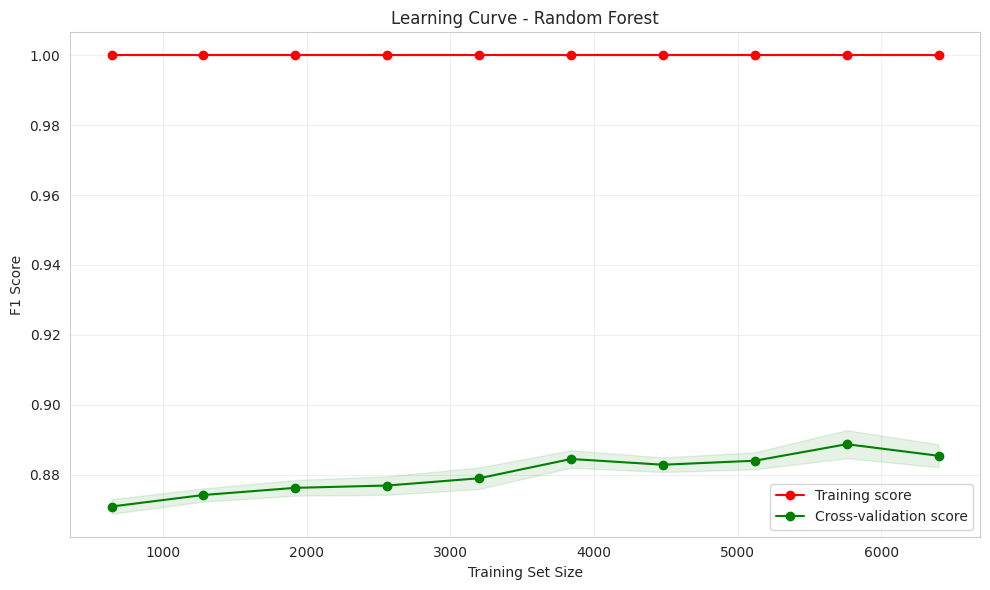

2. Logistic Regression Learning Curve


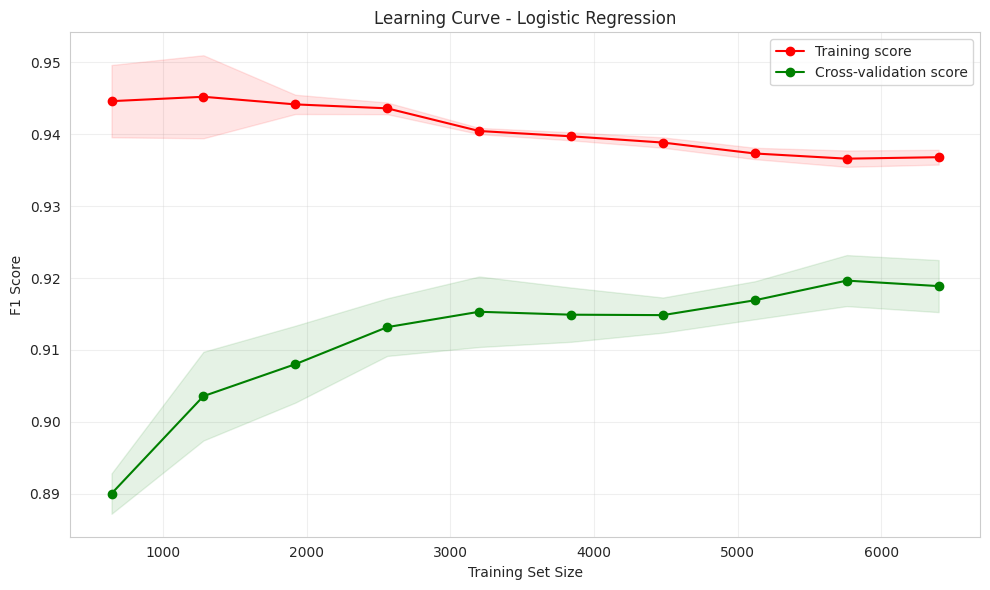

In [18]:
def plot_learning_curve(estimator, title, X, y, cv=5):
    """
    Generate learning curve plot
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

    plt.xlabel('Training Set Size')
    plt.ylabel('F1 Score')
    plt.title(f'Learning Curve - {title}')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Generating learning curves... This may take a few minutes.\n")

# Random Forest learning curve
print("1. Random Forest Learning Curve")
plot_learning_curve(best_rf, "Random Forest", X_train, y_train)

# Logistic Regression learning curve
print("2. Logistic Regression Learning Curve")
plot_learning_curve(best_lr, "Logistic Regression", X_train, y_train)

## Part 6: Model Interpretability with SHAP
### Understanding what features drive predictions

In [19]:
if SHAP_AVAILABLE:
    print("Computing SHAP values for Random Forest...")
    print("This may take several minutes...\n")

    # Sample for SHAP (use smaller subset for speed)
    sample_size = min(500, len(X_test))
    X_shap = X_test[:sample_size]

    # Create SHAP explainer
    explainer = shap.TreeExplainer(best_rf)
    shap_values = explainer.shap_values(X_shap)

    # For binary classification, get SHAP values for positive class
    if isinstance(shap_values, list):
        shap_values_pos = shap_values[1]
    else:
        shap_values_pos = shap_values

    print("SHAP values computed successfully!")
else:
    print("SHAP not available. Install with: pip install shap")
    print("Skipping interpretability analysis...")

Computing SHAP values for Random Forest...
This may take several minutes...

SHAP values computed successfully!



SHAP Summary Plot (Feature Importance):


<Figure size 1200x800 with 0 Axes>

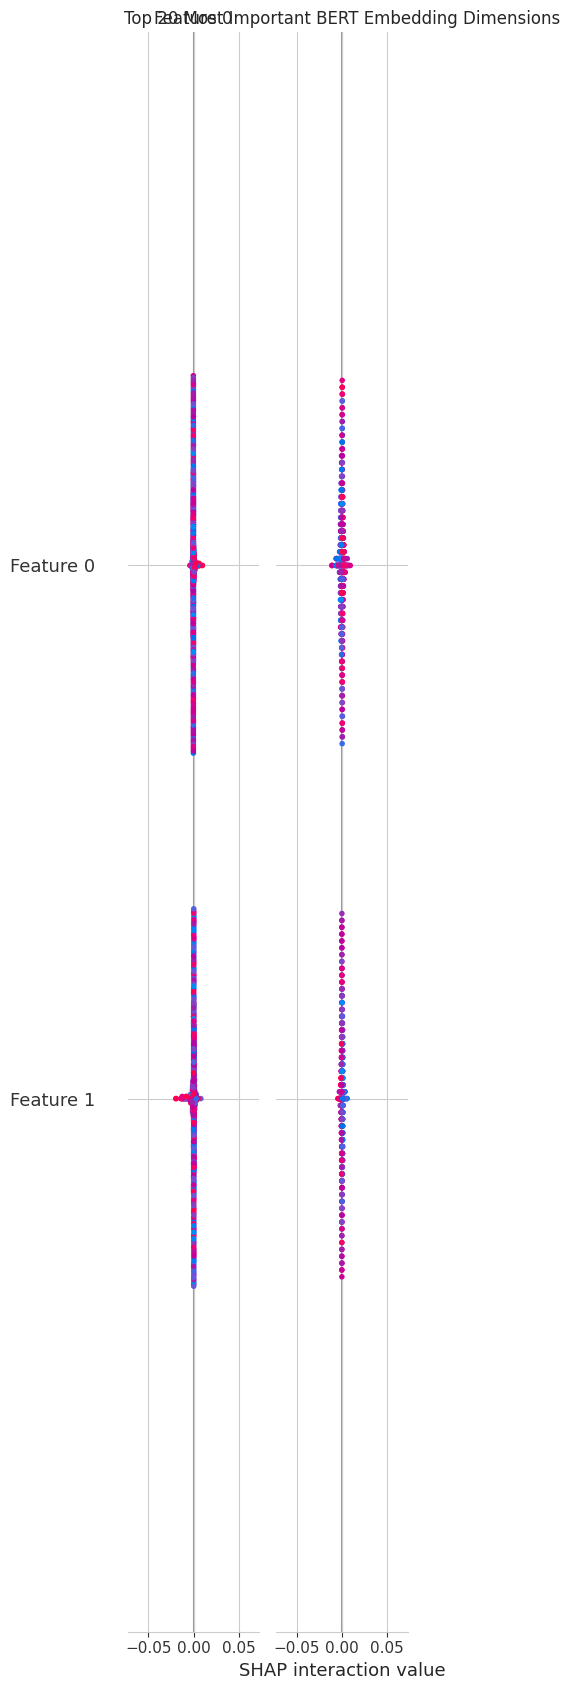


SHAP Beeswarm Plot (Feature Impact):


<Figure size 1200x800 with 0 Axes>

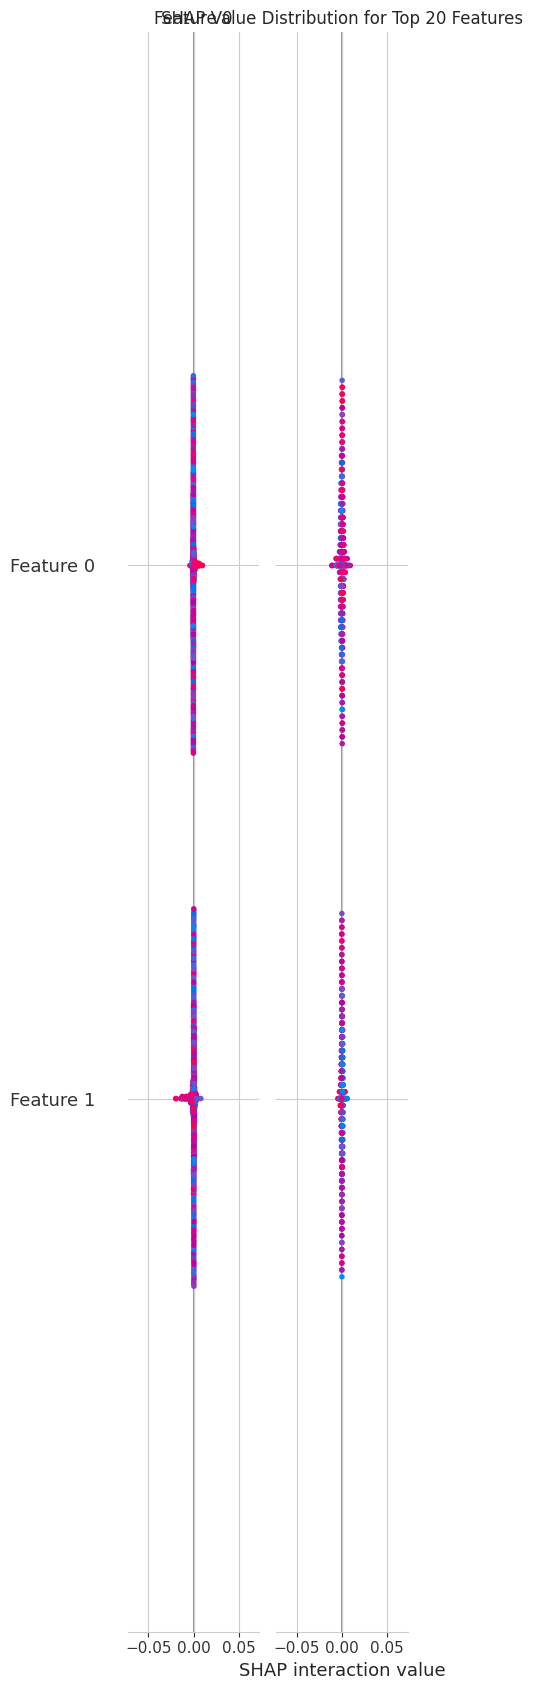

In [20]:
if SHAP_AVAILABLE:
    # Summary plot
    print("\nSHAP Summary Plot (Feature Importance):")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_pos, X_shap, plot_type="bar", show=False, max_display=20)
    plt.title('Top 20 Most Important BERT Embedding Dimensions')
    plt.tight_layout()
    plt.show()

    # Beeswarm plot
    print("\nSHAP Beeswarm Plot (Feature Impact):")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_pos, X_shap, show=False, max_display=20)
    plt.title('SHAP Value Distribution for Top 20 Features')
    plt.tight_layout()
    plt.show()

### Feature Importance from Random Forest

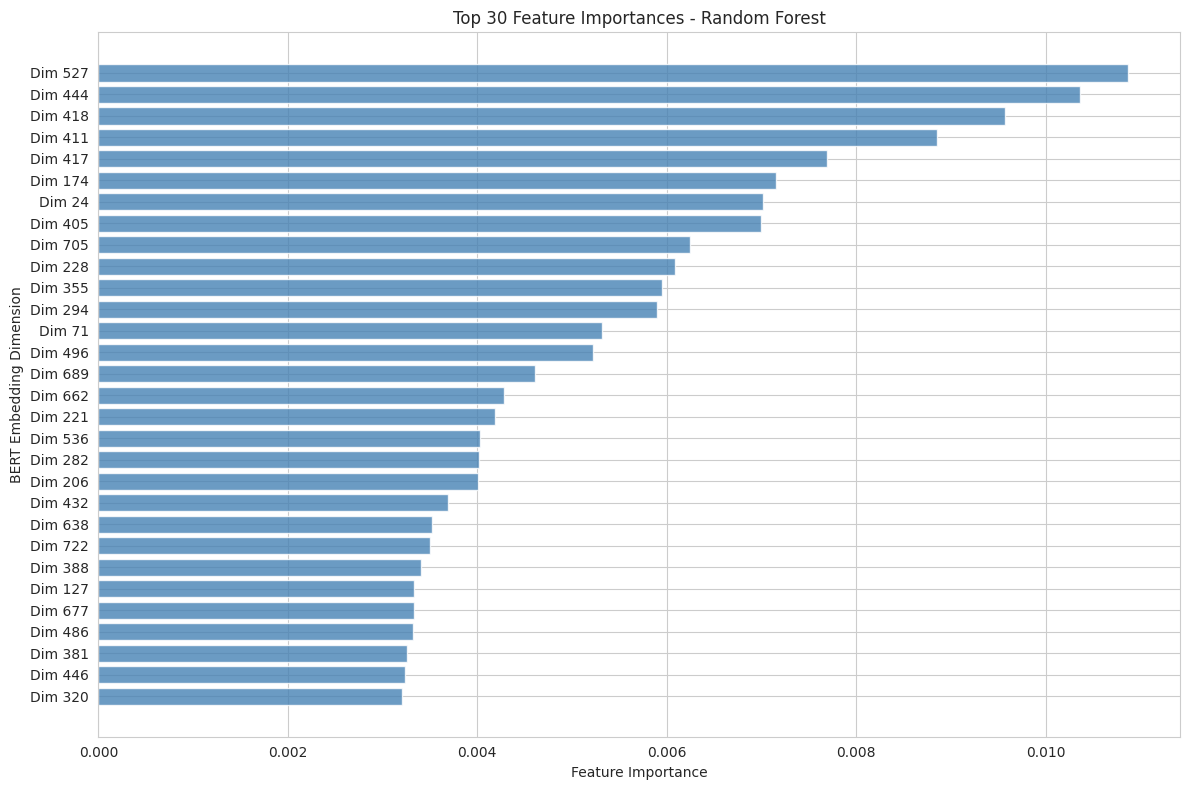


Top 10 most important dimensions:
1. Dimension 527: 0.010875
2. Dimension 444: 0.010368
3. Dimension 418: 0.009569
4. Dimension 411: 0.008849
5. Dimension 417: 0.007690
6. Dimension 174: 0.007148
7. Dimension 24: 0.007011
8. Dimension 405: 0.006995
9. Dimension 705: 0.006243
10. Dimension 228: 0.006083


In [21]:
# Get feature importances from Random Forest
feature_importances = best_rf.feature_importances_

# Sort and get top 30
top_indices = np.argsort(feature_importances)[-30:][::-1]
top_importances = feature_importances[top_indices]

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_importances)), top_importances, color='steelblue', alpha=0.8)
plt.xlabel('Feature Importance')
plt.ylabel('BERT Embedding Dimension')
plt.title('Top 30 Feature Importances - Random Forest')
plt.yticks(range(len(top_importances)), [f'Dim {i}' for i in top_indices])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop 10 most important dimensions:")
for i, (idx, imp) in enumerate(zip(top_indices[:10], top_importances[:10]), 1):
    print(f"{i}. Dimension {idx}: {imp:.6f}")

## Part 7: Fine-tuning BERT for Classification
### Train BERT end-to-end on COVID-19 data

In [22]:
# Load tokenizer
print("Loading BERT for fine-tuning...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained BERT for sequence classification
bert_classifier = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

bert_classifier.to(device)
print(f"BERT classifier loaded on {device}")

Loading BERT for fine-tuning...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT classifier loaded on cuda


In [23]:
# Prepare data for fine-tuning (use smaller sample for demonstration)
FINETUNE_SAMPLE_SIZE = 5000  # Adjust based on your resources

df_finetune = df.head(FINETUNE_SAMPLE_SIZE)

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_finetune['cleaned_text'].values,
    df_finetune['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df_finetune['label'].values
)

print(f"Fine-tuning dataset:")
print(f"  Training: {len(train_texts)} samples")
print(f"  Validation: {len(val_texts)} samples")

Fine-tuning dataset:
  Training: 4000 samples
  Validation: 1000 samples


In [24]:
# Tokenize data
MAX_LEN = 128

def tokenize_data(texts, labels, max_length=128):
    """
    Tokenize texts and create data loaders
    """
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            str(text),
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels_tensor = torch.tensor(labels)

    return input_ids, attention_masks, labels_tensor

print("Tokenizing training data...")
train_inputs, train_masks, train_labels_tensor = tokenize_data(train_texts, train_labels, MAX_LEN)

print("Tokenizing validation data...")
val_inputs, val_masks, val_labels_tensor = tokenize_data(val_texts, val_labels, MAX_LEN)

print(f"\nTokenization complete!")
print(f"Training inputs shape: {train_inputs.shape}")
print(f"Validation inputs shape: {val_inputs.shape}")

Tokenizing training data...
Tokenizing validation data...

Tokenization complete!
Training inputs shape: torch.Size([4000, 128])
Validation inputs shape: torch.Size([1000, 128])


In [25]:
# Create data loaders
BATCH_SIZE = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels_tensor)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(val_inputs, val_masks, val_labels_tensor)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

print(f"Data loaders created:")
print(f"  Training batches: {len(train_dataloader)}")
print(f"  Validation batches: {len(val_dataloader)}")

Data loaders created:
  Training batches: 250
  Validation batches: 63


In [26]:
# Setup optimizer and scheduler
EPOCHS = 3  # Adjust based on your time/resources
LEARNING_RATE = 2e-5

optimizer = AdamW(bert_classifier.parameters(), lr=LEARNING_RATE, eps=1e-8)

total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"\nTraining configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Total training steps: {total_steps}")


Training configuration:
  Epochs: 3
  Batch size: 16
  Learning rate: 2e-05
  Total training steps: 750


In [27]:
# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    """
    Train for one epoch
    """
    model.train()
    total_loss = 0

    for batch in dataloader:
        batch_inputs = batch[0].to(device)
        batch_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(
            batch_inputs,
            attention_mask=batch_masks,
            labels=batch_labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    return total_loss / len(dataloader)

# Validation function
def evaluate(model, dataloader, device):
    """
    Evaluate model on validation set
    """
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch_inputs = batch[0].to(device)
            batch_masks = batch[1].to(device)
            batch_labels = batch[2].to(device)

            outputs = model(
                batch_inputs,
                attention_mask=batch_masks,
                labels=batch_labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = batch_labels.cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(labels)

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    return avg_loss, accuracy, f1, predictions, true_labels

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


In [28]:
# Fine-tune BERT
print("\n" + "="*70)
print("FINE-TUNING BERT")
print("="*70)
print(f"\nThis will take approximately {EPOCHS * 5} - {EPOCHS * 10} minutes...\n")

training_stats = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 70)

    # Train
    train_loss = train_epoch(bert_classifier, train_dataloader, optimizer, scheduler, device)
    print(f"  Training Loss: {train_loss:.4f}")

    # Evaluate
    val_loss, val_acc, val_f1, _, _ = evaluate(bert_classifier, val_dataloader, device)
    print(f"  Validation Loss: {val_loss:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Validation F1: {val_f1:.4f}")

    training_stats.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_accuracy': val_acc,
        'val_f1': val_f1
    })

print("\n" + "="*70)
print("FINE-TUNING COMPLETE!")
print("="*70)


FINE-TUNING BERT

This will take approximately 15 - 30 minutes...


Epoch 1/3
----------------------------------------------------------------------
  Training Loss: 0.2467
  Validation Loss: 0.1498
  Validation Accuracy: 0.9430
  Validation F1: 0.9616

Epoch 2/3
----------------------------------------------------------------------
  Training Loss: 0.1208
  Validation Loss: 0.1638
  Validation Accuracy: 0.9530
  Validation F1: 0.9685

Epoch 3/3
----------------------------------------------------------------------
  Training Loss: 0.0866
  Validation Loss: 0.1737
  Validation Accuracy: 0.9530
  Validation F1: 0.9685

FINE-TUNING COMPLETE!


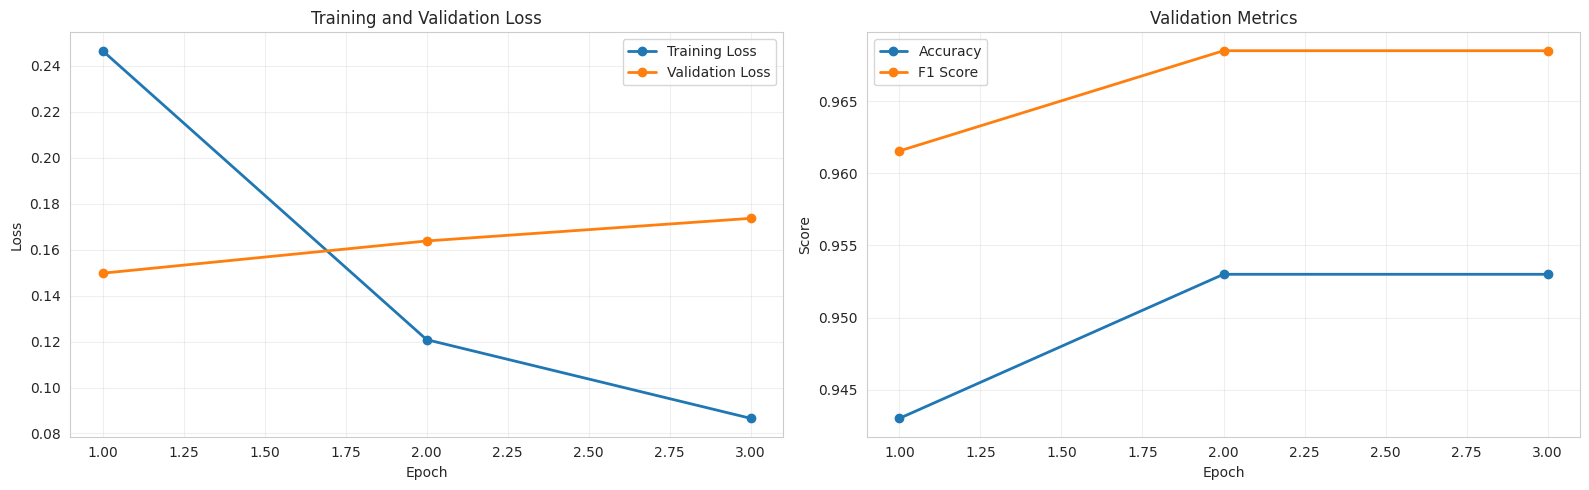

In [29]:
# Plot training history
stats_df = pd.DataFrame(training_stats)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss plot
axes[0].plot(stats_df['epoch'], stats_df['train_loss'], 'o-', label='Training Loss', linewidth=2)
axes[0].plot(stats_df['epoch'], stats_df['val_loss'], 'o-', label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Metrics plot
axes[1].plot(stats_df['epoch'], stats_df['val_accuracy'], 'o-', label='Accuracy', linewidth=2)
axes[1].plot(stats_df['epoch'], stats_df['val_f1'], 'o-', label='F1 Score', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


FINE-TUNED BERT - FINAL RESULTS

Validation Loss: 0.1737
Validation Accuracy: 0.9530
Validation Precision: 0.9837
Validation Recall: 0.9538
Validation F1: 0.9685

Classification Report:
              precision    recall  f1-score   support

 Non-Disease       0.87      0.95      0.91       242
     Disease       0.98      0.95      0.97       758

    accuracy                           0.95      1000
   macro avg       0.93      0.95      0.94      1000
weighted avg       0.96      0.95      0.95      1000



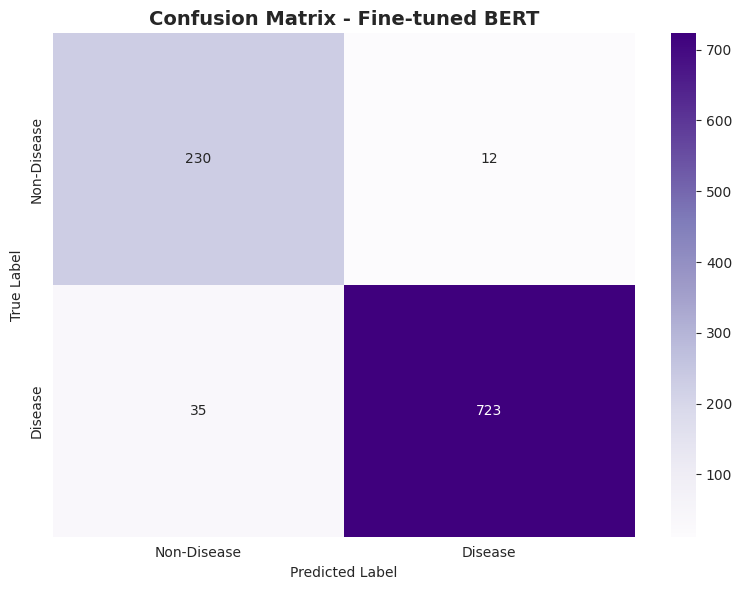

In [30]:
# Final evaluation on validation set
val_loss, val_acc, val_f1, val_predictions, val_true = evaluate(bert_classifier, val_dataloader, device)

print("\n" + "="*70)
print("FINE-TUNED BERT - FINAL RESULTS")
print("="*70)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {precision_score(val_true, val_predictions):.4f}")
print(f"Validation Recall: {recall_score(val_true, val_predictions):.4f}")
print(f"Validation F1: {val_f1:.4f}")

print("\nClassification Report:")
print(classification_report(val_true, val_predictions, target_names=['Non-Disease', 'Disease']))

# Confusion matrix
cm_bert = confusion_matrix(val_true, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Non-Disease', 'Disease'],
            yticklabels=['Non-Disease', 'Disease'])
plt.title('Confusion Matrix - Fine-tuned BERT', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Part 8: Model Comparison Summary

In [31]:
# Create comprehensive comparison
comparison_data = [
    {
        'Model': 'Random Forest (Tuned)',
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Precision': precision_score(y_test, y_pred_rf),
        'Recall': recall_score(y_test, y_pred_rf),
        'F1-Score': f1_score(y_test, y_pred_rf),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_rf)
    },
    {
        'Model': 'Logistic Regression (Tuned)',
        'Accuracy': accuracy_score(y_test, y_pred_lr),
        'Precision': precision_score(y_test, y_pred_lr),
        'Recall': recall_score(y_test, y_pred_lr),
        'F1-Score': f1_score(y_test, y_pred_lr),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_lr)
    },
    {
        'Model': 'Voting Classifier',
        'Accuracy': accuracy_score(y_test, y_pred_voting),
        'Precision': precision_score(y_test, y_pred_voting),
        'Recall': recall_score(y_test, y_pred_voting),
        'F1-Score': f1_score(y_test, y_pred_voting),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_voting)
    },
    {
        'Model': 'Stacking Classifier',
        'Accuracy': accuracy_score(y_test, y_pred_stacking),
        'Precision': precision_score(y_test, y_pred_stacking),
        'Recall': recall_score(y_test, y_pred_stacking),
        'F1-Score': f1_score(y_test, y_pred_stacking),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_stacking)
    },
    {
        'Model': 'Fine-tuned BERT',
        'Accuracy': val_acc,
        'Precision': precision_score(val_true, val_predictions),
        'Recall': recall_score(val_true, val_predictions),
        'F1-Score': val_f1,
        'ROC-AUC': '-'  # Would need probabilities
    }
]

if XGBOOST_AVAILABLE and xgb_classifier:
    comparison_data.insert(2, {
        'Model': 'XGBoost',
        'Accuracy': accuracy_score(y_test, y_pred_xgb),
        'Precision': precision_score(y_test, y_pred_xgb),
        'Recall': recall_score(y_test, y_pred_xgb),
        'F1-Score': f1_score(y_test, y_pred_xgb),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_xgb)
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*90)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*90)
print(comparison_df.to_string(index=False))

# Find best model by F1
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_f1 = comparison_df.loc[best_model_idx, 'F1-Score']

print(f"\n{'='*90}")
print(f"BEST MODEL: {best_model_name} (F1-Score: {best_f1:.4f})")
print(f"{'='*90}")


COMPREHENSIVE MODEL COMPARISON
                      Model  Accuracy  Precision   Recall  F1-Score   ROC-AUC
      Random Forest (Tuned)    0.8060   0.810016 0.974460  0.884661   0.87579
Logistic Regression (Tuned)    0.8780   0.903713 0.940406  0.921694   0.94202
                    XGBoost    0.8565   0.905759 0.906352  0.906056   0.91452
          Voting Classifier    0.8790   0.895385 0.952849  0.923223  0.935373
        Stacking Classifier    0.8810   0.903569 0.944990  0.923816  0.940813
            Fine-tuned BERT    0.9530   0.983673 0.953826  0.968520         -

BEST MODEL: Fine-tuned BERT (F1-Score: 0.9685)


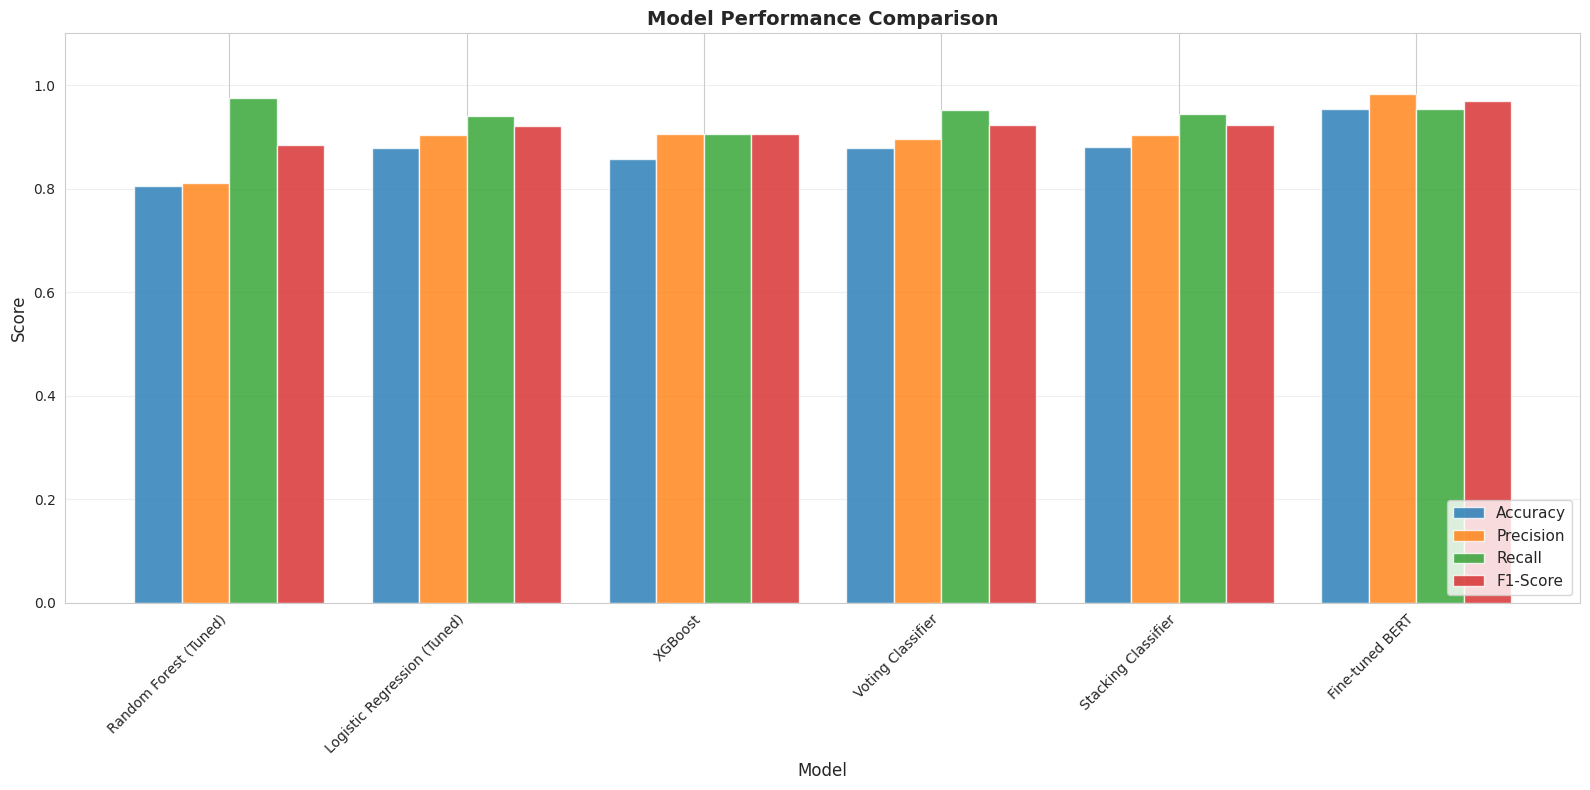

In [32]:
# Visualize model comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df))
width = 0.2

fig, ax = plt.subplots(figsize=(16, 8))

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, comparison_df[metric], width, label=metric, alpha=0.8)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Save All Models

In [33]:
# Save all models
print("Saving models...")

with open('rf_tuned.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

with open('lr_tuned.pkl', 'wb') as f:
    pickle.dump(best_lr, f)

with open('voting_classifier.pkl', 'wb') as f:
    pickle.dump(voting_clf, f)

with open('stacking_classifier.pkl', 'wb') as f:
    pickle.dump(stacking_clf, f)

if XGBOOST_AVAILABLE and xgb_classifier:
    with open('xgb_classifier.pkl', 'wb') as f:
        pickle.dump(xgb_classifier, f)

# Save fine-tuned BERT
bert_classifier.save_pretrained('bert_finetuned')
tokenizer.save_pretrained('bert_finetuned')

# Save comparison results
comparison_df.to_csv('model_comparison.csv', index=False)

print("\nAll models saved successfully!")
print("  - Random Forest (tuned)")
print("  - Logistic Regression (tuned)")
print("  - XGBoost" if XGBOOST_AVAILABLE else "")
print("  - Voting Classifier")
print("  - Stacking Classifier")
print("  - Fine-tuned BERT")
print("  - Model comparison results")

Saving models...

All models saved successfully!
  - Random Forest (tuned)
  - Logistic Regression (tuned)
  - XGBoost
  - Voting Classifier
  - Stacking Classifier
  - Fine-tuned BERT
  - Model comparison results


In [34]:
# Final summary
print("\n" + "="*90)
print("PHASE 2.5 COMPLETE: Advanced ML & BERT Fine-tuning")
print("="*90)
print("\n✅ Completed:")
print("  ✓ Cross-validation (5-fold)")
print("  ✓ Hyperparameter tuning (Grid Search)")
print("  ✓ ROC-AUC curves")
print("  ✓ Precision-Recall curves")
print("  ✓ XGBoost classifier" if XGBOOST_AVAILABLE else "  - XGBoost (not available)")
print("  ✓ Ensemble methods (Voting, Stacking)")
print("  ✓ Learning curves")
print("  ✓ SHAP interpretability" if SHAP_AVAILABLE else "  - SHAP (not available)")
print("  ✓ Feature importance analysis")
print("  ✓ Fine-tuned BERT classifier")
print("  ✓ Comprehensive model comparison")
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")
print("\n📊 All results saved to: backend/data/models/ and backend/data/processed/")



PHASE 2.5 COMPLETE: Advanced ML & BERT Fine-tuning

✅ Completed:
  ✓ Cross-validation (5-fold)
  ✓ Hyperparameter tuning (Grid Search)
  ✓ ROC-AUC curves
  ✓ Precision-Recall curves
  ✓ XGBoost classifier
  ✓ Ensemble methods (Voting, Stacking)
  ✓ Learning curves
  ✓ SHAP interpretability
  ✓ Feature importance analysis
  ✓ Fine-tuned BERT classifier
  ✓ Comprehensive model comparison

🏆 Best Model: Fine-tuned BERT
   F1-Score: 0.9685

📊 All results saved to: backend/data/models/ and backend/data/processed/
